<a href="https://colab.research.google.com/github/minthammock/cap-stone/blob/dev/capstone_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Action Items

0.   Add various preprocessings to the existing models and get glove model working
1.   Finish model narrative
2.   Explore the word embeddings for our corpus
3.   Finish Dash Application
4.   Create Non-technical
5.   Consider what adding the author does to prediction







# Abstract
This paper is a first attempt at using neural network technology to determine the truth value of short, headline like, statements. Since the proliferation of social media as a primary means of spreading mis-information, society, world wide, has been reeling from the effects. Here in the United States, mis-information has been used as a tool for undermining our most fundamental democratic institutions and is quickly erroding the moral and cohesion of local communities. Since the beginning of the mis-information plague, there have yet to be any widely used tools which can combat mis-information with reasonable surety. Perhaps this is due to the fact that a lie takes only a moment to create but hours to fully debunk. To be clear, this paper is an exploration of neural networks and their ability to discern truth with varying degrees of information. At this point, the models are not performing well enough to be used as a digital vaccine to the larger problem. It is my hope that the work in this paper will be improved upon by others to create a lasting light in the dark sea of lies we have all been swimming in. 

At the end of this paper, you will understand the modeling appraoch we took and the final model itself. 

CRISP-DM was my methodology of choice. Now to the matter at hand.

# Business Understanding
Given the intent of my work is to act as a defense against mis-information on social media, we will focus on business case for companies like facebook, instagram, twitter and the like. Other expansions are desired in the end, but for the sake of keeping the problem reasonably narrow, text versions of social media will the be the target. 

## Why Care About Misinformation?
It's worth asking, why would social media companies care about verifying the truth value of content posed to their applications? Any normal person would understand that the answer involves doing the right thing. For those of you not convinced I'll contine on. How about money? Everyone likes money right? While the total cost of mis-information is difficult to acertain and hard to quantify, CHEQ AI, a cybersecurity compancy that uses AI to protect others from mis-information, commissened a study run by professor Roberto Cavazos from the University of Baltimore to quantify the cost of mis-information on businesses in the US and abraod. You can find the whole article <a src="https://s3.amazonaws.com/media.mediapost.com/uploads/EconomicCostOfFakeNews.pdf"> here </a>, but the general conclusions are the following.
* 37 billion in losses on the stock market
* 17 billion in losses annually from false/misleading financial information
* 9.54 billion spent on reputation management for false information about companies
* 3 billion has been already spent to combat fake news
* 400 million spent by US public institutions defending against misinformation
* 250 million spent on brand safety measure

All in all, the report concluded that 78 billion dollars have been spent either combating or attempting to prevent misinformation in the recent past. This is just the direct costs that could be found. The price tag for indirect consequences is unknown and assumed to be many times greater than what can be directly attributed to mis-information. 

Not all of this applies directly to social media companies, but as the host for much of the fake news, their share of the burden is significant. In 2018, Facebook's CEO claimed that the company's annual budget for defending against mis-information was more than 3 billion dollars. This includes over 30000 positions world-wide which are dedicated content monitors. While not a leagal scholar, the relationship social media has to fake news isn't completely detached. Several governments world-wide have entered into agreements with social media companies to fight versions of mis-information that may be deemed bad for the public or governmental institutions. This relationship is costly for the companies and often required in order to cunduct business around the world. 

Given this is paper is being written at the end of 2020, I've reserved a specific shout out for COVID-19. Misinformation has taken a human life toll on the US in the year following the outbreak of COVID-19. The ensuing social and commercial restrictions have negatively impacted hundreds of thousands of individuals and businesses world-wide. As the primary income for most social media platforms is advertising dollars, the overall downturn of the global economy due to the virus has hit the pockets of social media companies. The handeling of the virus has been negatively effected by the dissemination of fake news, whereby prolonging the economic damage. As the pandemic is still raging and vaccines have only just begin being distributed, the total cost is still unknown. But there can be little doubt it will be a very large number. I'm interested to see how much of the total cost will be attributed to mis-information when the dust settles. 

## What is the Business Objective
Having made the case why social media companien should - and currently do - care about mis-information, let's move on to the more important question. What is the business solution? There are several differnt versions of what monitoring for mis-information can take on. The scale ranges from simple identification to more advanced methods of targetted sensorship. Any case begins with the ability to determine the truth value of statements posted to social media. As such, the primary business objective is to create a way to effectively categorize user generated text as to the level of truth it contains in a cost effective manner. Ideally, this will be done with some level of specificity.

No model is perfect, and I take personal care when thinking about integrating AI into a system that makes decisions about people. In the interest of staying away from the messy world of sensorship let's go on the idea that the best integration will  




# Code Logistics

## Dependancies

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, MultiHeadAttention
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils  import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
import nltk
from nltk import word_tokenize

import pandas as pd
import numpy as np

import os

## Custom Classes

In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
        
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Custom Functions

In [ ]:
def create_model_visuals(model, train, X_test, y_test, X_train = None, y_train = None,  batch_size = 32, epochs = 20,kwargs = {}):
  params = locals()

  def create_matrix(X,y, normalize = 'true'):
    y_hat = model.predict(X)
    y_hat = [x.argmax() for x in y_hat]
    y_eval = [x.argmax() for x in y.values]
    confusionMatrix = confusion_matrix(y_eval, y_hat, normalize=normalize)
    dfConfustionMatrix = pd.DataFrame(confusionMatrix, columns=y.columns, index = y.columns)
    dfConfustionMatrix.index.name = 'Predictions'
    dfConfustionMatrix.columns.name = 'True'

    fig,ax = plt.subplots(1,1,figsize = (10,8))
    sns.heatmap(
        dfConfustionMatrix, 
        annot=True, 
        cmap = 'Blues',
        ax = ax,
    )

    ax.set(
        title = 'Confustion Matrix',
        xlabel = 'Predicted Label',
        ylabel = 'True Label'
    )

    report = pd.DataFrame.from_dict(classification_report(y_eval, y_hat,output_dict=True))
    report.columns = [x for x in y_test_OH.columns] + ['Accuracy', 'Macro_Avg', 'Weighted_Avg']
    display(report)



  if train == True:
    y_train_OH = pd.get_dummies(y_train)
    y_test_OH = pd.get_dummies(y_test)
    modelHistory = model.fit(
        x = X_train, 
        y = y_train_OH,
        batch_size=batch_size,
        epochs=epochs,
        **kwargs)
    
    model.evaluate(X_test, y_test_OH)

    create_matrix(X_test, y_test_OH) 

    dfModel = pd.DataFrame().from_dict(modelHistory.history)
    fig, ((ax1,ax2)) = plt.subplots(nrows = 2,ncols = 1, figsize = (18,10))
    dfModel.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics', xlabel = 'Training Generation', ylabel = 'Loss score');
    dfModel.plot(y = ['categorical_accuracy', 'val_categorical_accuracy'],ax = ax2, title = 'categorical_accuracy',xlabel = 'Training Generation', ylabel = 'Accuracy Percentage');
    plt.tight_layout()
    plt.show()
     
  else:
    y_test_OH = pd.get_dummies(y_test)
    dfModel = None
    model.evaluate(X_test, y_test_OH)
    create_matrix(X_test, y_test_OH) 
 
  return dfModel,params

# Copy the repo from Github

In [ ]:
! git clone https://github.com/minthammock/cap-stone

fatal: destination path 'cap-stone' already exists and is not an empty directory.


# Data Understanding
The data used for this paper was pulled from Politifact.com. Politifact is a lovely organization that takes the time to investigate viral claims that deal with hot or sensative topics. Unsurprisingly, many of these claims are political in nature, but not strictly so. Politifact investigates these claims from variosu sources and writes a small article summarizing their findings as to the validity of the content. They do the hard work! If you find this paper at all interesting it might be worth sending a little money their way. 5 bucks people, I'm not asking for the moon. Anyways, Politifact vets the claims and boils it down to six distinct categories: Pants on fire, false, barly-true, half-true and true. Pants fire is a special category reserved for falsehoods that not only lack any semblence of truth, but are also particularly outlandish or detrimental. A good example would be, "The democrates say they are going to blow up the moon." The classifications are somewhat subjective but because professionals took the time to look into the truth and cite their sources, I hold the labels as gold standard when it comes to verifying the level of truth in a statement. 

There's one problem with this approach. Research is hard and Politifact has only done 19000 evaluations over the past 12 years or so. Yes, that's a lot of investigations, but not when thinking about NLP neural networks which are often trained on bodies of work as large as all of wikipedia.

Because of the raw data limitation, I'm skeptical of the ability to classify truth to say +80% accuracy. Ultimately, the work done here will need to be supercharged with data in order to reach it's true potential. For now, let's take a look at what we have. 

An important consideration ever present in modeling is class imbalance. Here's our given composition.

<img src="https://drive.google.com/uc?id=1EjxE9yDNB9mj2lFiUfnypbdTDUOcZMKC" />

The imbalence is not as severe as it could be, but this still merits adjusting for. Sci-kit learn has a particular function which calculated the weights needed for each class in order to mimic balanced amounts of data. This is the primary tool I am going to use to address the imbalance, please see the code sections for specifics on the implementation. 

With imbalance addressed we will take a detour into the data itself. Our dataset includes 18436 different records. These records have three text columns. Our target column is the truth_value column which is the basis of our supervised learning task for this paper. In addition, we have a column of quotes which are consumed by our model in order to make predictions on the truth value. The final column is the author column which routinely accounts for the person or organization responsible for the creation of the quote. 

What do these columns look like? The next visual represents the 10 most frequent authors and the breakdown of their quotes into the various truth values. 

<img src="https://drive.google.com/uc?id=1gL4xn0HS9aSG4sG4O38i6uVu8MV_Zqlh" />

With the rise of social media, it makes sense that those at the top of the list are figures in the modern political scene. In general, Politifact reviews quotes with implications for the real world. With the prolification of mis-information as a political tool, much of their work has centered on uncovering the truth behind statements made in the political sphere. Please note that there are lumped categories such as "Facebook posts" and "Viral image". These categories include quotes that achieved viral status in spreading through social media sites. You won't find a good definition of viral in this paper as the exact criteria used to determine what elevates something to viral status isn't exactly clear. For a better sense of the nature of the quotes themselves, please see the hosted application for this paper. 

Given the top authors are pulled mostly from the political realm, it follows that words common in modern political times are highly represented. Check out the following two word clouds for a more intuitive idea about the nature of the quotes corpus. This example excludes stop words from consideration (the, and, where, in, is, I, etc...).

<img 
  src="https://drive.google.com/uc?id=1aJmMaPmbhdrM2VB7OGGISv7sRhe61na4" 
/>

Unsuprizingly, the word cloud that excludes stop words consists of what we might expect: Words about hot topic issues, words about the voting process, locations, individuals in politics, money, governmental institutions and the like. 

Summary statistics are also worth considering. While using the quotes to determine the truth value will ultimately be the job of our models, let's see if there's any differences we can spot that might seperate the classes at hand. 

<img 
  src="https://drive.google.com/uc?id=1pMjZ6eUHw2rFrXjsCD-ip3LTxS9xVG7Q" 
/>

This confirms the majority of our quotes are short in length. Looking at the medain of the data - denoted by the black line in the middle of the boxes - there are some slight differences among the various truth value categories. The two falsehood categories pants-fire and false have the fewest words on average, approximately 14 and 15 words respectively. Mostly-true, barely-true and true all have nearly identical medians, that being a word or two more than the false categories. Half-true statements had the largest median at around 18 words. 

The overall spread of each categories distributions are roughly similar or at least, aren't unique enough to give immediate insight into the relationship between quote word count and the underlying truth value. 

This concludes our exploration into the dataset. Because the purpose of this paper isn't to analyze the impact of the author on our model's ability to determine truth values, we will omit further investigation into that column. Ultimately, a holistic approach to determining the underlying truth of posts on media can and should include all available information available to make classifications. I will consider adding more information in an ending section if time allows. 

# Code for Data Exploration

## General EDA code

In [ ]:
# read in the data and put in a dataframe
dfTemp = pd.read_json('./cap-stone/politifact_info.json', orient='', )
df = pd.DataFrame()
# rename the columns to the correct names
for column in dfTemp.columns:
  df[column] = dfTemp[column][0]

In [ ]:
# display some basic info to make sure things loaded in ok
display(df.head())
display(df.describe())
display(df['truth_value'].value_counts())

,author,quote,truth_value
0,Facebook posts,Says the new coronavirus vaccines contain toxi...,pants-fire
1,Bloggers,21% of people are having serious adverse event...,false
2,Ted Cruz,Says that guidance urging vaccinated people to...,pants-fire
3,Facebook posts,A 2018 executive order gives Trump the ability...,pants-fire
4,Facebook posts,President Donald Trump will hold his inaugurat...,pants-fire


,author,quote,truth_value
count,18436,18436,18436
unique,4263,18413,9
top,Facebook posts,On changing the rules for filibusters on presi...,false
freq,1051,3,4240


false          4240
half-true      3265
mostly-true    3088
barely-true    3019
true           2348
pants-fire     2218
full-flop       162
half-flip        69
no-flip          27
Name: truth_value, dtype: int64

We aren't attempting to determine whether someone is changing their position. Thus we drop all target rows that are not focused on truth values specifically. 

In [ ]:
# There are 3 values of the truth value column that we aren't interested in. Drop them
drop1 = df.loc[df['truth_value'] == 'full-flop'].index
drop2 = df.loc[df['truth_value'] == 'half-flip'].index
drop3 = df.loc[df['truth_value'] == 'no-flip'].index

# re-display the data info to make sure the drop took
dfFinal = df.drop(index = drop1.append(drop2).append(drop3))
display(dfFinal['truth_value'].value_counts())
display(dfFinal.describe())

false          4240
half-true      3265
mostly-true    3088
barely-true    3019
true           2348
pants-fire     2218
Name: truth_value, dtype: int64

,author,quote,truth_value
count,18178,18178,18178
unique,4248,18168,6
top,Facebook posts,Says a series of photos show Iranian rockets b...,false
freq,1051,2,4240


## Create Visuals

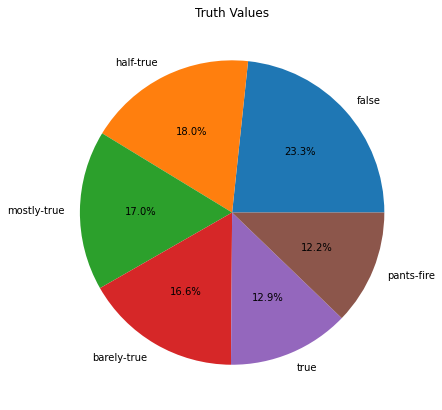

In [ ]:
# Create the pie chart plot for the narrative
plot1 = dfFinal.truth_value.value_counts().plot.pie(
    y = 'truth_value',
    figsize = (7,7),
    title = 'Truth Values',
    ylabel = '',
    autopct='%1.1f%%'
)

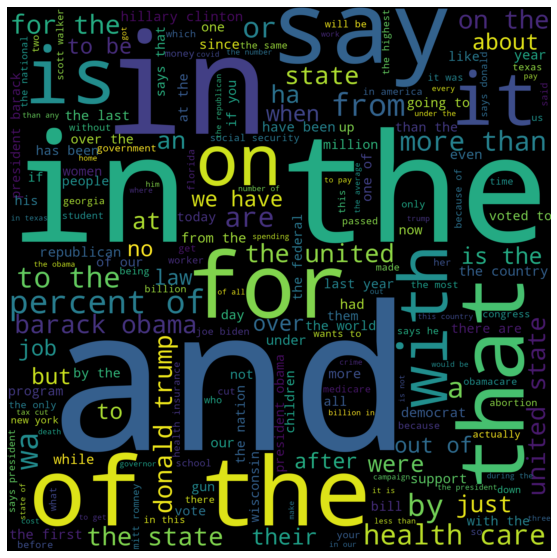

In [ ]:
# # Create a countvectorizer object and fit on out quotes
# counter = CountVectorizer()
# counterFit = counter.fit_transform(dfFinal.quote)

# #cast the counter object to an array
# counts = counterFit.toarray().sum(axis = 0)
# names = counter.get_feature_names()

# # create a dictionary to count the words 
# wordCounts = {}
# for i in range(len(counts)):
#   wordCounts[names[i]] = counts[i]
# sortedWordCounts = {k:v for k,v in sorted(wordCounts.items(), key = lambda item: item[1], reverse=True)}

# leave stopwords empty for the first word cloud
stopwords = []

# create a world cloud 
wordcloud = WordCloud(stopwords = stopwords,
                      width = 1000,
                      height = 1000,
                      scale = 2,
                      collocations=True).generate(' '.join(dfFinal.quote).lower())

#plot the wordcloud object
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

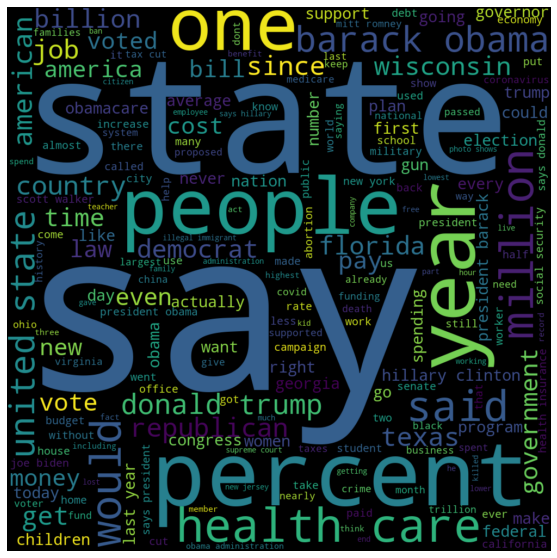

In [ ]:
# add a list of stop words to not consider for word cloud
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

# Create another word cloud
wordcloud = WordCloud(
    stopwords = stopwords,
    collocations=True,
    width = 1000,
    height = 1000)\
      .generate(' '.join(dfFinal.quote).lower())

#plot the wordcloud object
plt.figure(figsize=(10,10))

plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

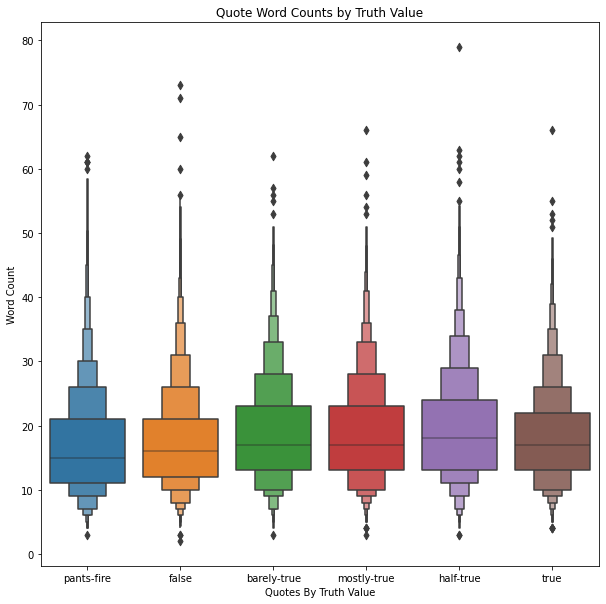

In [ ]:
def get_average_lengths(df):
  container = pd.DataFrame([])
  quote_length = {}
  for value in dfFinal.truth_value.unique():
    total_length = 0
    temp = dfFinal.loc[dfFinal.truth_value == value]
    for y in temp.quote:
      total_length += len(y.split())
    container[value] = [round(total_length / temp.shape[0], 0)]
  return container

# create a new column that counts the words for each quote
dfFinal['word_count'] = dfFinal['quote'].map(lambda x: len(x.split()))

# create a boxenplot 
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.boxenplot(
    x = dfFinal.truth_value,
    y = dfFinal.word_count,
    ax = ax,
)

# set the visual parameters for the plot
ax.set(
    title = 'Quote Word Counts by Truth Value',
    xlabel = 'Quotes By Truth Value',
    ylabel = 'Word Count'
);

In [ ]:
# setup a new dataframe that groupsby author and counts the various truth_values

#group by author
dfFinalInitial = dfFinal.groupby('author').count()

#breakout the truth_values column with pd.get_dummies
dfFinalIntermediate = pd.get_dummies(data = dfFinal, columns=['truth_value'])

# aggregate the data with sum
dfFinalEncodded = dfFinalIntermediate.groupby('author').sum()

# create a column of the totals
dfFinalEncodded['total'] = dfFinalInitial['truth_value']

# sort the dataframe by authors with the most quotes 
dfFinalEncodded = dfFinalEncodded.sort_values('total', axis = 0, ascending=False)
dfFinalEncodded.head()

,word_count,truth_value_barely-true,truth_value_false,truth_value_half-true,truth_value_mostly-true,truth_value_pants-fire,truth_value_true,total
author,,,,,,,,
Facebook posts,19559,110.0,542.0,73.0,37.0,271.0,18.0,1051
Donald Trump,16348,187.0,335.0,119.0,84.0,155.0,35.0,915
Bloggers,8614,43.0,155.0,22.0,18.0,355.0,8.0,601
Barack Obama,10387,69.0,70.0,153.0,158.0,9.0,117.0,576
Viral image,10236,40.0,297.0,22.0,8.0,189.0,3.0,559


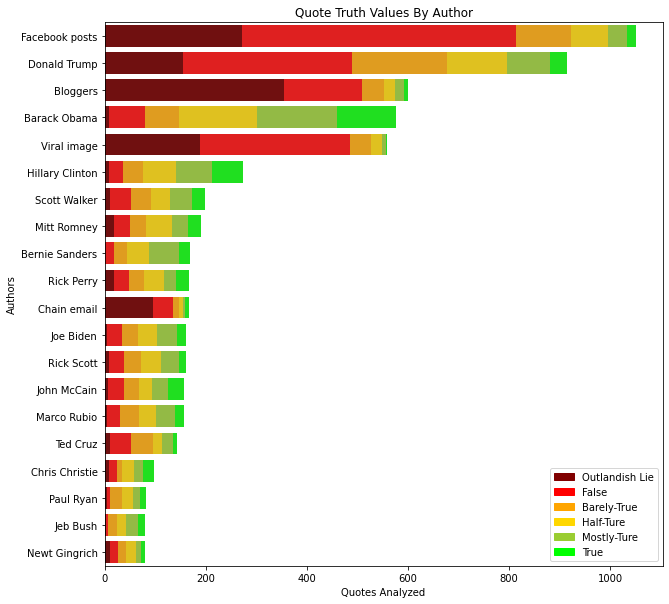

In [ ]:
# create an obnoxious graph that shows the various truth values by author
fig, ax = plt.subplots(1,1,figsize = (10,10))

# we are only going to display the top 20
dfFinalGroup20 = dfFinalEncodded[:20].drop(columns = ['word_count'])

# because of seaborn and matplot lib, you have to do 6 different barplot objects plot them at the end of the previous one
sns.barplot(
    y = dfFinalGroup20.index,
    x = dfFinalGroup20['truth_value_pants-fire'],
    dodge = False,
    orient = 'h',
    color = 'maroon',
    ax = ax,
)

#plot 2
sns.barplot(
    y = dfFinalGroup20.index,
    x = dfFinalGroup20['truth_value_false'],
    dodge = False,
    orient = 'h',
    color = 'red',
    ax = ax,
    left = dfFinalGroup20['truth_value_pants-fire']
)

# plot 3
sns.barplot(
    y = dfFinalGroup20.index,
    x = dfFinalGroup20['truth_value_barely-true'],
    dodge = False,
    orient = 'h',
    color = 'orange',
    ax = ax,
    left = dfFinalGroup20['truth_value_false'] + dfFinalGroup20['truth_value_pants-fire']
)

#plot4
sns.barplot(
    y = dfFinalGroup20.index,
    x = dfFinalGroup20['truth_value_half-true'],
    dodge = False,
    orient = 'h',
    color = 'gold',
    ax = ax,
    left = dfFinalGroup20['truth_value_barely-true'] + \
           dfFinalGroup20['truth_value_false'] + \
           dfFinalGroup20['truth_value_pants-fire']
)

#plot 5
sns.barplot(
    y = dfFinalGroup20.index,
    x = dfFinalGroup20['truth_value_mostly-true'],
    dodge = False,
    orient = 'h',
    color = 'yellowgreen',
    ax = ax,
    left = dfFinalGroup20['truth_value_half-true'] +\
           dfFinalGroup20['truth_value_barely-true'] + \
           dfFinalGroup20['truth_value_false'] + \
           dfFinalGroup20['truth_value_pants-fire']
)

# plot 6
sns.barplot(
    y = dfFinalGroup20.index,
    x = dfFinalGroup20['truth_value_true'],
    dodge = False,
    orient = 'h',
    color = 'lime',
    ax = ax,
    left = dfFinalGroup20['truth_value_mostly-true'] +\
           dfFinalGroup20['truth_value_half-true'] +\
           dfFinalGroup20['truth_value_barely-true'] + \
           dfFinalGroup20['truth_value_false'] + \
           dfFinalGroup20['truth_value_pants-fire']
           
)

# There are no labels, need to define the labels
legend_labels  = ['Outlandish Lie', 'False', 'Barely-True', 'Half-Ture', 'Mostly-Ture', 'True']
colors = ['maroon', 'red', 'orange', 'gold', 'yellowgreen', 'lime']

# Create the legend patches
legend_patches = [matplotlib.patches.Patch(color=C, label=L) for
                  L, C in zip(legend_labels, colors)]

# Plot the legend
plt.legend(handles=legend_patches)

# customize the plot labels
ax.set(
    title = 'Quote Truth Values By Author',
    xlabel = 'Quotes Analyzed',
    ylabel = 'Authors'
);

## Train Test Split Without Author

In [ ]:
# seperate out the target and corpus
X = dfFinal['quote']
y = dfFinal['truth_value']

# perform our train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .05)

# recode the target column to the one hot encodded version.
y_train_OH = pd.get_dummies(y_train)
y_test_OH = pd.get_dummies(y_test)

In [ ]:
# use sci-kit learns class weights funtion to find the balanced weights for out target classes
class_weights = compute_class_weight('balanced', y_train_OH.columns, y_train)

#recreate this as a dictionary to be fed into our keras model
class_weights = {
    0 : class_weights[0],
    1 : class_weights[1],
    2 : class_weights[2],
    3 : class_weights[3],
    4 : class_weights[4],
    5 : class_weights[5]
}

## Tokenize and 

In [ ]:
wordToVec = Word2Vec(sentences = X_train, size=150, window=35, min_count=1, workers=4)
wordToVec.train(X_train, total_examples=wordToVec.corpus_count, epochs=5)
wv = wordToVec.wv

# Data Preperation for Modeling
Data preprocessing is a stick subject in the NLP universe. I'm going to break my approach into two distict methods: TF-IDF and Embeddings. Ultimately, this paper will show results for each preperation method for all models available (tuning will be done behind the scenes). I think it's worth breaking the preperation into two distinct categories to reflect the two major NLP approaches. The first approach relies on creating a frequency distribution (TF-IDF in our case) and further engineering the resulting tokens through linguistics measures such as stemming and lemmatezation. limited size n_grams will also be considered. The second approach is the embedding technique. Typically, with neural networks, we limit the amount of feature engineering prior to modeling. A neural network may be able to extract information out of various elements (word tense, punctuation, etc..) that would be eliminated with extensive linguistic feature engineering. 

Regardless of the vectorization method, all NLP models must begin with word tokenizing. Running the corpus through a generic keras tokenizer yields just over 19000 unique tokens/words. Because we are analyzing quotes we must establish a uniform length to trim or pad the word sequences. I am choosing 40 as the length as informed by the mean word count visual. 40 tokens per sequence will avoid trimming information for the vase majority of our data. While introducing added zeroes is not ideal, I believe the descision to add empty data should be prioritized over trimming data. 



## Tokenize

In [ ]:
# Only consider the first 40 words of each movie review
maxlen = 40  

In [ ]:
# tokenize our corpus. There are less than 20000 words but this gives a buffer for future production versions
tokenizerTrain = text.Tokenizer(num_words=20000)

# fit this on our corpus
tokenizerTrain.fit_on_texts(X_train)

# transform our corpus into tokenized sequences
list_tokenized_entry = tokenizerTrain.texts_to_sequences(X_train)

# make all the sequences the same length for the model
X_train_tokens = sequence.pad_sequences(list_tokenized_entry, maxlen=maxlen)
print(X_train_tokens.shape)

# do the same steps for the test set
tokenizerTest = text.Tokenizer(num_words=20000)
tokenizerTest.fit_on_texts(X_train)
list_tokenized_entry = tokenizerTest.texts_to_sequences(X_test)
X_test_tokens = sequence.pad_sequences(list_tokenized_entry, maxlen=maxlen)
X_test_tokens.shape

(17269, 40)


(909, 40)

# Baseline Model
The baseilne model is used to establish a baseline for future model iterations. In some cases we might introduce a random guessing models as the baseline, however, in this case, given the complex nature of NLP models, I believe it makes more sense begin with a naive bayes classifer. Naive bayes was traditionally used for high dimensional data, NLP being the foremost example. I would like to note that much of the text preprocessing already done is primarily to support this baseline. For neural network models, much of the preprocessing is left out in order to allow the network to ascertain which features are most important rather than feature engineering using TF-IDF and n-grams. Here is the test set confustion matrix.

<img src = '' />

All in all the baseline model doesn't perform significantly different than a random guess (1/6 = 18%). This is not unexpected given the difficult task of determining truth value given only a short phrase. The performace underscores the importance of finding solutions to this problem, and highlights the any models that show insight into answers. Because the naive bayes model is serving as a baseline, not much attention was given to adjusting hyperparameters (of which naive bayes has relatively few). This will be addressed in an appendix if time allows.

,barely-true,false,half-true,mostly-true,pants-fire,true,Accuracy,Macro_Avg,Weighted_Avg
precision,0.145833,0.225490,0.224138,0.260417,0.176329,0.165414,0.193619,0.199603,0.203285
recall,0.044872,0.120419,0.147727,0.166667,0.561538,0.207547,0.193619,0.208128,0.193619
f1-score,0.068627,0.156997,0.178082,0.203252,0.268382,0.184100,0.193619,0.176574,0.172637
support,156.000000,191.000000,176.000000,150.000000,130.000000,106.000000,0.193619,909.000000,909.000000


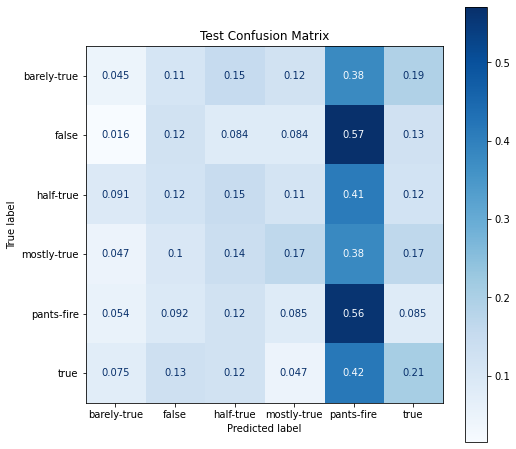

In [ ]:
baselineModel = MultinomialNB()
baselineModel.fit(X_train_tokens, y_train, )
baselineModel.predict(X_test_tokens)

y_pred = baselineModel.predict(X_test_tokens)
report = pd.DataFrame.from_dict(classification_report(y_test, y_pred,output_dict=True))
report.columns = [x for x in y_test_OH.columns] + ['Accuracy', 'Macro_Avg', 'Weighted_Avg']
display(report)

fig,ax = plt.subplots(1,1,figsize = (8,8))


baselineConfusion = plot_confusion_matrix(
    baselineModel, 
    X_test_tokens, 
    y_test, 
    normalize='true',
    ax = ax,
    cmap = 'Blues',
)

ax.set(
  title = 'Test Confusion Matrix'
);

# LSTM Neural Network
With Naive Bayes showing little promise as a potential modeling solution, we turn to neural networks and deep NLP. For now we will focus on letting the model control the embedding, later we will use pre-trained embeddings to explore transfer learning.

LSTM, until recently, was on the cutting edge of deep NLP breakthroughs. The underlying premise is to create internal states for the nodes of model, such that, they can keep track of words and their associated embeddings. In this specific model we will use two layers of LSTM cells, collapse our word dimensions with a globalaveragepooling layer and feed the results into a 1-hidden layer dense network. For all details of the model architecture, please see the code below. 

The results were both exciting and underwhelming. 

<img src = "" />

How about the good? We have successfully passed the random guessing threshold! If you look at the confusion matrix you'll see the model is capable of picking up on the truth values for our text samples. Even more encouraging is are the clear relationships that the model is drawing from the various categories. By this, I mean, truth values that are more closely related to one another tend to have the best scores for any one category. Yes, there is still a very high rate of misclassification, but because the model is making associations (such as false examples most commonly getting classified as pants-fire) I'm hopeful that additional data will improve these metrics. 

Now the bad. This model is not production worthy. Our overall accuracy is encouraging, but not sufficient to the level such that it could reasonable make actionable predictions in a live enviornment. Moreover, getting data to increase the model's preformace is going to be somewhat difficult. There are other sources of truth vetting that were not considered in this project. A future iteration of this project may attempt to bring this data in, but it is worth acknowledging the hurdel exists, especially since labels from other data likely won't match up to Politifact. 





In [ ]:
# Create a keras model using the functional API

input = keras.Input(shape=(maxlen,))
# x = vectorizer_tfidf(input)
x = Embedding(
      input_dim = len(vectorizer_tfidf.get_vocabulary()),
      output_dim = 150,
      # embeddings_initializer=keras.initializers.Constant(embedding_matrix),
      trainable=True,
    )(input)
x = LSTM(100, return_sequences=True,)(x)
x = LSTM(50, return_sequences=True,)(x)
# x = LSTM(50, return_sequences=True,)(x)

x = GlobalAveragePooling1D()(x)
x = Dense(
      100,
      activation = 'relu',
      )(x)
x = Dropout(.3)(x)
x = Dense(
      25, 
      activation = 'relu',
      )(x)

output = Dense(6, activation='softmax')(x)

model = keras.models.Model(input, output, name = 'LSTM_model')

model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.RMSprop(), 
    metrics=[
      keras.metrics.CategoricalAccuracy(),
    ]
)

model.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 150)           3000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 100)           100400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 50)            30200     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

Epoch 1/25
122/122 [==============================] - 6s 26ms/step - loss: 1.7854 - categorical_accuracy: 0.1607 - val_loss: 1.7537 - val_categorical_accuracy: 0.1888


INFO:tensorflow:Assets written to: first_model/assets


INFO:tensorflow:Assets written to: first_model/assets


Epoch 2/25
122/122 [==============================] - 2s 18ms/step - loss: 1.7003 - categorical_accuracy: 0.2206 - val_loss: 1.7287 - val_categorical_accuracy: 0.2148


INFO:tensorflow:Assets written to: first_model/assets


INFO:tensorflow:Assets written to: first_model/assets


Epoch 3/25
122/122 [==============================] - 3s 24ms/step - loss: 1.6194 - categorical_accuracy: 0.2594 - val_loss: 1.7716 - val_categorical_accuracy: 0.2154


INFO:tensorflow:Assets written to: first_model/assets


INFO:tensorflow:Assets written to: first_model/assets


Epoch 4/25
122/122 [==============================] - 2s 18ms/step - loss: 1.5582 - categorical_accuracy: 0.2966 - val_loss: 1.7577 - val_categorical_accuracy: 0.2339


INFO:tensorflow:Assets written to: first_model/assets


INFO:tensorflow:Assets written to: first_model/assets


Epoch 5/25
122/122 [==============================] - 2s 18ms/step - loss: 1.4398 - categorical_accuracy: 0.3613 - val_loss: 1.8109 - val_categorical_accuracy: 0.2490


INFO:tensorflow:Assets written to: first_model/assets


INFO:tensorflow:Assets written to: first_model/assets


Epoch 6/25
122/122 [==============================] - 3s 22ms/step - loss: 1.3687 - categorical_accuracy: 0.4147 - val_loss: 1.8727 - val_categorical_accuracy: 0.2328
Epoch 7/25
122/122 [==============================] - 2s 18ms/step - loss: 1.2874 - categorical_accuracy: 0.4555 - val_loss: 1.9446 - val_categorical_accuracy: 0.2287
Epoch 8/25
122/122 [==============================] - 2s 18ms/step - loss: 1.2365 - categorical_accuracy: 0.4936 - val_loss: 2.0188 - val_categorical_accuracy: 0.2328
Epoch 9/25
122/122 [==============================] - 2s 18ms/step - loss: 1.1759 - categorical_accuracy: 0.5340 - val_loss: 2.0797 - val_categorical_accuracy: 0.2281
Epoch 10/25
29/29 [==============================] - 0s 5ms/step - loss: 2.0711 - categorical_accuracy: 0.2519


,barely-true,false,half-true,mostly-true,pants-fire,true,Accuracy,Macro_Avg,Weighted_Avg
precision,0.251309,0.256545,0.282443,0.191667,0.373832,0.189349,0.251925,0.257524,0.258892
recall,0.307692,0.256545,0.210227,0.153333,0.307692,0.301887,0.251925,0.256229,0.251925
f1-score,0.276657,0.256545,0.241042,0.170370,0.337553,0.232727,0.251925,0.252482,0.251582
support,156.000000,191.000000,176.000000,150.000000,130.000000,106.000000,0.251925,909.000000,909.000000


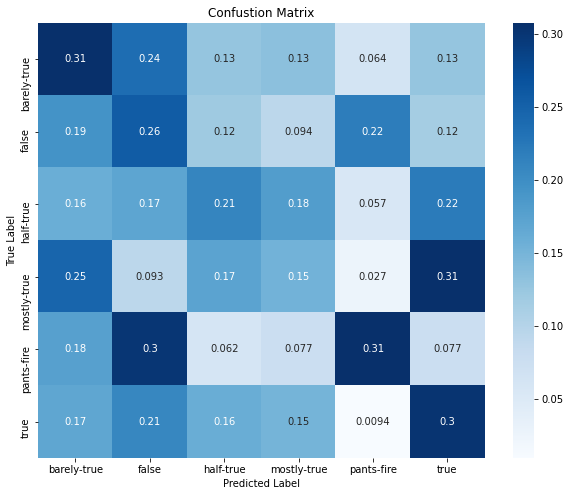

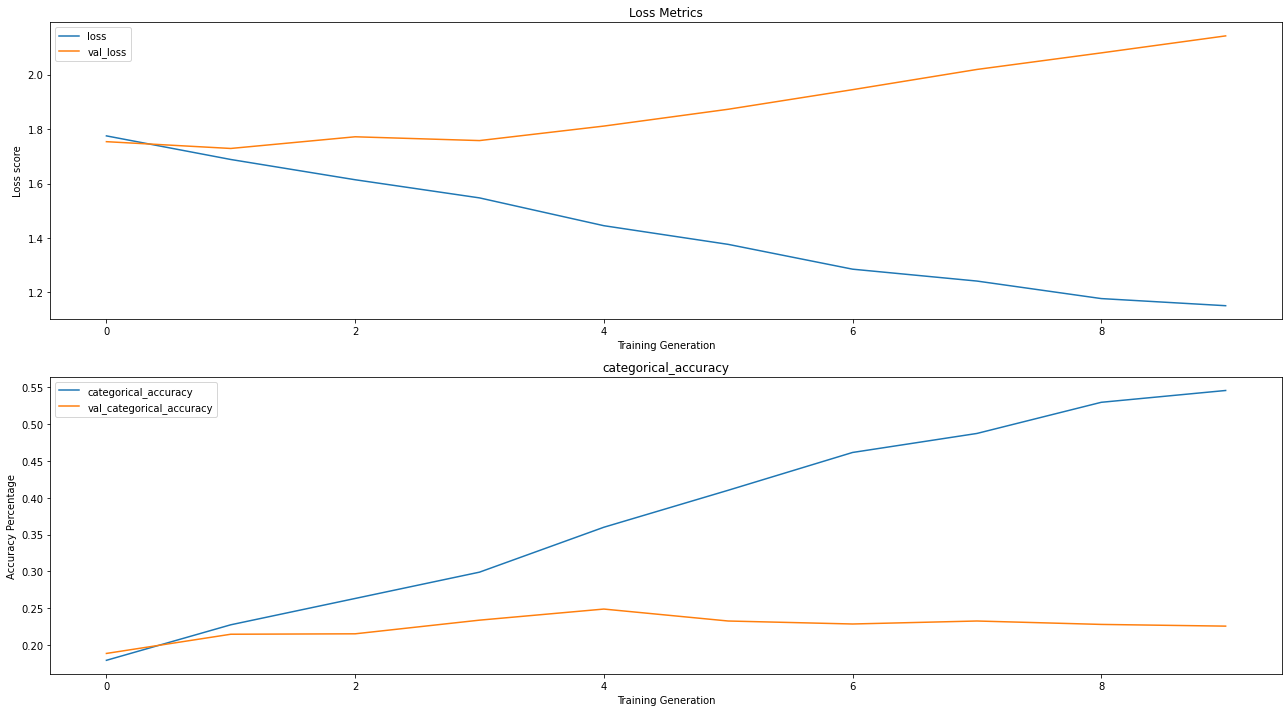

In [ ]:
# we define the filepath where any results will be saved
firstModel_filepath = os.path.join('first_model')

# the Callbacks for keras.Model.fit() method. See Keras documentation for more info.
firstModelEarlyStop = EarlyStopping(patience= 5, mode = 'auto', restore_best_weights=False, monitor='val_categorical_accuracy')
firstModelCheckpoint = ModelCheckpoint(firstModel_filepath,save_best_only=True, monitor='val_categorical_accuracy')
firstModelLRAdjust = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience=2, min_delta=.00000000001)

# This cell runs the fitting 
firstModelHistory,params = create_model_visuals(
    model = model, 
    X_train= X_train_tokens, 
    y_train = y_train_OH,
    X_test = X_test_tokens,
    y_test = y_test_OH,
    epochs = 25, 
    batch_size=128,
    train = True,
    kwargs = {
        'validation_split': .1,
        'class_weight' : class_weights,
        'callbacks':[firstModelCheckpoint, firstModelEarlyStop, firstModelLRAdjust]
        })

29/29 [==============================] - 0s 4ms/step - loss: 2.0711 - categorical_accuracy: 0.2519


,barely-true,false,half-true,mostly-true,pants-fire,true,Accuracy,Macro_Avg,Weighted_Avg
precision,0.251309,0.256545,0.282443,0.191667,0.373832,0.189349,0.251925,0.257524,0.258892
recall,0.307692,0.256545,0.210227,0.153333,0.307692,0.301887,0.251925,0.256229,0.251925
f1-score,0.276657,0.256545,0.241042,0.170370,0.337553,0.232727,0.251925,0.252482,0.251582
support,156.000000,191.000000,176.000000,150.000000,130.000000,106.000000,0.251925,909.000000,909.000000


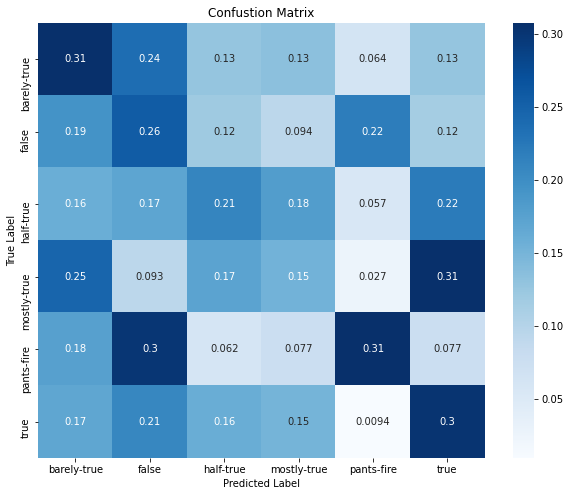

In [ ]:
checkpointModel = keras.models.load_model('first_model')
checkpointModelHistory, checkpointModelParams = create_model_visuals(
    model = model, 
    X_test = X_test_tokens,
    y_test = y_test_OH,
    train = False,
 )

# Multi-head Attention Transformer
Attention is a hot word in the deep learning world at the moment. With the publication of "Attention is all you need" by Vaswani et al, attention mechanisms have been heavily studied in a wide variety of deep learning fields. More recently, the notion of self-attention arose and offered an interesting alternative to LSTM and other memory state models. Self-attention achieved state of the art results on NLP staple challenges with the BERT implementaion of self-attention by Devlin et al (2019). Fortunately, Keras has adopted a self-attention transformer class that is available <a src = "https://keras.io/examples/nlp/text_classification_with_transformer" >here. </a> Below is the keras implementation with only slight adjustments made to tailor the model architechture to this specific NLP task. 

In [ ]:
embed_dim =  150 # Embedding size for each token
num_heads = 15  # Number of attention heads
ff_dim = 150  # Hidden layer size in feed forward network inside transformer

# Use the class at the beginning of the paper to create two embeddings
# one for the word itself and one for the words locatgion in the quote
embedding_layer = TokenAndPositionEmbedding(maxlen, 20000, embed_dim)

# use the class at the beginning of the paper that defined the keras implementation for a transformer model
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

# create the keras model
inputs = layers.Input(shape=(maxlen,))
x = embedding_layer(inputs)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(100, activation="relu",
                 kernel_initializer=keras.initializers.Orthogonal(),
                 )(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(50, activation="relu", 
                 kernel_initializer=keras.initializers.Orthogonal(),
                 )(x)
outputs = layers.Dense(6, activation="softmax")(x)

transformerModel = keras.Model(inputs=inputs, outputs=outputs)
transformerModel.compile(keras.optimizers.RMSprop(), "categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
transformerModel.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
token_and_position_embedding (None, 40, 150)           3006000   
_________________________________________________________________
transformer_block (Transform (None, 40, 150)           136500    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 150)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050  

Epoch 1/50
243/243 [==============================] - 6s 17ms/step - loss: 1.8162 - categorical_accuracy: 0.1624 - val_loss: 1.7836 - val_categorical_accuracy: 0.1627


INFO:tensorflow:Assets written to: transformer_model/assets


INFO:tensorflow:Assets written to: transformer_model/assets


Epoch 2/50
243/243 [==============================] - 4s 17ms/step - loss: 1.7414 - categorical_accuracy: 0.2020 - val_loss: 1.7072 - val_categorical_accuracy: 0.2108


INFO:tensorflow:Assets written to: transformer_model/assets


INFO:tensorflow:Assets written to: transformer_model/assets


Epoch 3/50
243/243 [==============================] - 4s 16ms/step - loss: 1.6496 - categorical_accuracy: 0.2338 - val_loss: 1.6921 - val_categorical_accuracy: 0.2432


INFO:tensorflow:Assets written to: transformer_model/assets


INFO:tensorflow:Assets written to: transformer_model/assets


Epoch 4/50
243/243 [==============================] - 4s 16ms/step - loss: 1.5706 - categorical_accuracy: 0.2902 - val_loss: 1.8427 - val_categorical_accuracy: 0.2200
Epoch 5/50
243/243 [==============================] - 4s 15ms/step - loss: 1.4796 - categorical_accuracy: 0.3381 - val_loss: 1.7915 - val_categorical_accuracy: 0.2472


INFO:tensorflow:Assets written to: transformer_model/assets


INFO:tensorflow:Assets written to: transformer_model/assets


Epoch 6/50
243/243 [==============================] - 4s 16ms/step - loss: 1.3250 - categorical_accuracy: 0.4218 - val_loss: 1.9839 - val_categorical_accuracy: 0.2664


INFO:tensorflow:Assets written to: transformer_model/assets


INFO:tensorflow:Assets written to: transformer_model/assets


Epoch 7/50
243/243 [==============================] - 4s 16ms/step - loss: 1.2197 - categorical_accuracy: 0.4990 - val_loss: 1.8156 - val_categorical_accuracy: 0.2669


INFO:tensorflow:Assets written to: transformer_model/assets


INFO:tensorflow:Assets written to: transformer_model/assets


Epoch 8/50
243/243 [==============================] - 4s 16ms/step - loss: 1.0978 - categorical_accuracy: 0.5683 - val_loss: 2.1358 - val_categorical_accuracy: 0.2698


INFO:tensorflow:Assets written to: transformer_model/assets


INFO:tensorflow:Assets written to: transformer_model/assets


Epoch 9/50
243/243 [==============================] - 4s 16ms/step - loss: 1.0229 - categorical_accuracy: 0.5981 - val_loss: 2.2746 - val_categorical_accuracy: 0.2727


INFO:tensorflow:Assets written to: transformer_model/assets


INFO:tensorflow:Assets written to: transformer_model/assets


Epoch 10/50
243/243 [==============================] - 4s 16ms/step - loss: 0.9362 - categorical_accuracy: 0.6462 - val_loss: 2.5026 - val_categorical_accuracy: 0.2669
Epoch 11/50
243/243 [==============================] - 4s 16ms/step - loss: 0.8894 - categorical_accuracy: 0.6591 - val_loss: 2.4981 - val_categorical_accuracy: 0.2536
Epoch 12/50
243/243 [==============================] - 4s 15ms/step - loss: 0.8413 - categorical_accuracy: 0.6902 - val_loss: 2.6713 - val_categorical_accuracy: 0.2583
Epoch 13/50
243/243 [==============================] - 4s 16ms/step - loss: 0.8216 - categorical_accuracy: 0.6912 - val_loss: 2.7219 - val_categorical_accuracy: 0.2617
Epoch 14/50
29/29 [==============================] - 0s 4ms/step - loss: 2.5872 - categorical_accuracy: 0.2585


,barely-true,false,half-true,mostly-true,pants-fire,true,Accuracy,Macro_Avg,Weighted_Avg
precision,0.209677,0.303922,0.239264,0.214286,0.384615,0.247423,0.258526,0.266531,0.264867
recall,0.263514,0.276786,0.228070,0.250000,0.321101,0.212389,0.258526,0.258643,0.258526
f1-score,0.233533,0.289720,0.233533,0.230769,0.350000,0.228571,0.258526,0.261021,0.260290
support,148.000000,224.000000,171.000000,144.000000,109.000000,113.000000,0.258526,909.000000,909.000000


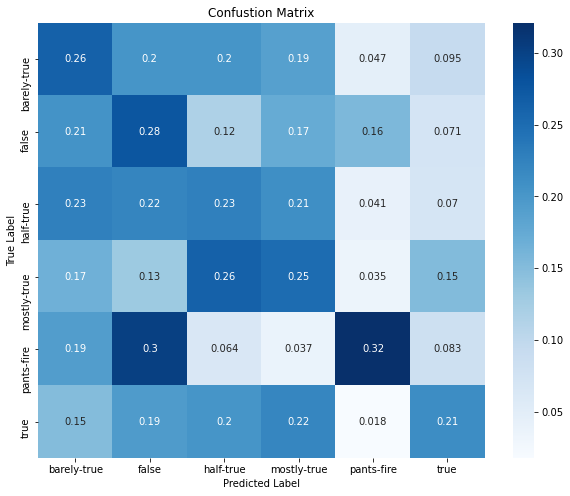

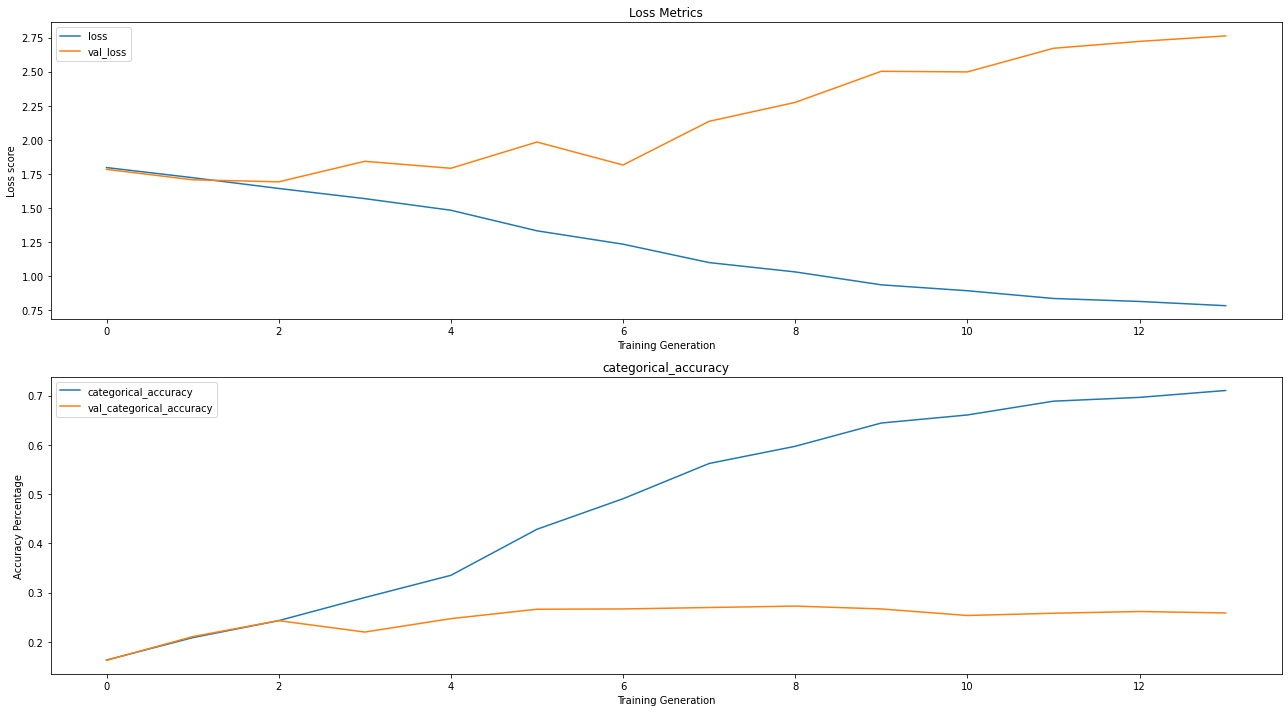

In [ ]:
# we define the filepath where any results will be saved
transformerModel_filepath = os.path.join('transformer_model')

# the Callbacks for keras.Model.fit() method. See Keras documentation for more info.
transformerModelEarlyStop = EarlyStopping(patience = 5, mode = 'auto', restore_best_weights=False, monitor='val_categorical_accuracy')
transformerModelCheckpoint = ModelCheckpoint(transformerModel_filepath,save_best_only=True, monitor='val_categorical_accuracy')
transformerModelLRAdjust = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience=2, min_delta=.00000000001)

# This cell runs the fitting 
transformerModelHistory,params = create_model_visuals(
    model = transformerModel, 
    X_train= X_train_tokens, 
    y_train = y_train_OH,
    X_test = X_test_tokens,
    y_test = y_test_OH,
    epochs = 50, 
    batch_size=64,
    train = True,
    kwargs = {
        'class_weight' : class_weights,
        'validation_split': .1,
        'callbacks':[transformerModelEarlyStop, transformerModelCheckpoint, transformerModelLRAdjust]})

29/29 [==============================] - 0s 5ms/step - loss: 2.5872 - categorical_accuracy: 0.2585


,barely-true,false,half-true,mostly-true,pants-fire,true,Accuracy,Macro_Avg,Weighted_Avg
precision,0.209677,0.303922,0.239264,0.214286,0.384615,0.247423,0.258526,0.266531,0.264867
recall,0.263514,0.276786,0.228070,0.250000,0.321101,0.212389,0.258526,0.258643,0.258526
f1-score,0.233533,0.289720,0.233533,0.230769,0.350000,0.228571,0.258526,0.261021,0.260290
support,148.000000,224.000000,171.000000,144.000000,109.000000,113.000000,0.258526,909.000000,909.000000


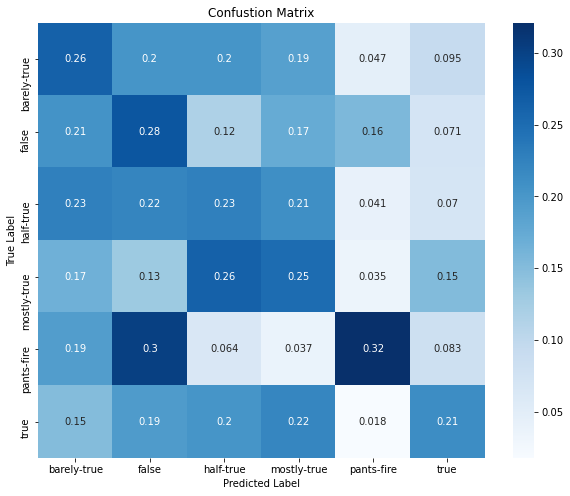

In [ ]:
checkpointTransformerModel = keras.models.load_model('transformer_model')
checkpointTransformerModelHistory,checkpointTransformerModelParams  = create_model_visuals(
    model = transformerModel, 
    
    X_test = X_test_tokens,
    y_test = y_test_OH,
    train = False,
)

# Combining Labels
Our first run through the modeling process has yielded interesting results as the neural networks are creating appropriate associations between the various truth values. While the overall accuracy isn't what we would like to see, it also isn't entirely necessary that we break the truth into so many categories. We will go through a couple iterations of collapsing out existing categories in logical ways to see if a more coarse assignment might create a more useful classification model. 

## Mapping 1

In [ ]:
def data_collapse(y, assignmentDict):
  return y.map(assignmentDict)

In [ ]:
mapping1 = {
    'pants-fire' : 'false',
    'false' : 'false',
    'barely-true' : 'some-truth',
    'half-true' : 'some-truth',
    'mostly-true' : 'substantially-true',
    'true' : 'substantially-true'
}

In [ ]:
y_train_map1 = data_collapse(y_train, mapping1)
y_test_map1 = data_collapse(y_test, mapping1)

y_train_map1_OH = pd.get_dummies(y_train_map1)
y_test_map1_OH = pd.get_dummies(y_test_map1)
display(y_train_map1.value_counts())

class_weights = compute_class_weight('balanced', y_train_map1_OH.columns, y_train_map1)
class_weights = {
    0 : class_weights[0],
    1 : class_weights[1],
    2 : class_weights[2],
}
print()
print(f'The weights are as follows: false : {class_weights[0]}, some-truth : {class_weights[1]}, substantially-true : {class_weights[2]}')

false                 6149
some-truth            5955
substantially-true    5165
Name: truth_value, dtype: int64


The weights are as follows: false : 0.9361413780018432, some-truth : 0.9666386789812482, substantially-true : 1.114488544691836


In [ ]:
# Only consider the first 50 words of each movie review
maxlen = 30

In [ ]:
embed_dim =  150 # Embedding size for each token
num_heads = 15  # Number of attention heads
ff_dim = 150  # Hidden layer size in feed forward network inside transformer

embedding_layer = TokenAndPositionEmbedding(maxlen, 20000, embed_dim)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

inputs = layers.Input(shape=(maxlen,))
x = embedding_layer(inputs)

x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.Orthogonal())(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.Orthogonal())(x)
outputs = layers.Dense(3, activation="softmax")(x)

transformerModel = keras.Model(inputs=inputs, outputs=outputs)
transformerModel.compile(keras.optimizers.RMSprop(momentum=.355), "categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
transformerModel.summary()


Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
token_and_position_embedding (None, 30, 150)           3004500   
_________________________________________________________________
transformer_block_45 (Transf (None, 30, 150)           136500    
_________________________________________________________________
global_average_pooling1d_36  (None, 150)               0         
_________________________________________________________________
dropout_184 (Dropout)        (None, 150)               0         
_________________________________________________________________
dense_413 (Dense)            (None, 100)               15100     
_________________________________________________________________
dropout_185 (Dropout)        (None, 100)               0  

Epoch 1/15
243/243 [==============================] - 4s 10ms/step - loss: 1.1223 - categorical_accuracy: 0.3498 - val_loss: 1.0471 - val_categorical_accuracy: 0.4331


INFO:tensorflow:Assets written to: transformer_model_mapping1/assets


INFO:tensorflow:Assets written to: transformer_model_mapping1/assets


Epoch 2/15
243/243 [==============================] - 2s 9ms/step - loss: 1.0455 - categorical_accuracy: 0.4381 - val_loss: 1.0100 - val_categorical_accuracy: 0.4823


INFO:tensorflow:Assets written to: transformer_model_mapping1/assets


INFO:tensorflow:Assets written to: transformer_model_mapping1/assets


Epoch 3/15
243/243 [==============================] - 2s 9ms/step - loss: 0.9946 - categorical_accuracy: 0.4934 - val_loss: 1.0114 - val_categorical_accuracy: 0.4748
Epoch 4/15
243/243 [==============================] - 2s 9ms/step - loss: 0.9502 - categorical_accuracy: 0.5302 - val_loss: 1.0180 - val_categorical_accuracy: 0.4783
Epoch 5/15
29/29 [==============================] - 0s 4ms/step - loss: 1.0160 - categorical_accuracy: 0.4851


,false,some-truth,substantially-true,Accuracy,Macro_Avg,Weighted_Avg
precision,0.595745,0.445378,0.447950,0.485149,0.496357,0.497259
recall,0.453074,0.483283,0.523985,0.485149,0.486781,0.485149
f1-score,0.514706,0.463557,0.482993,0.485149,0.487085,0.486739
support,309.000000,329.000000,271.000000,0.485149,909.000000,909.000000


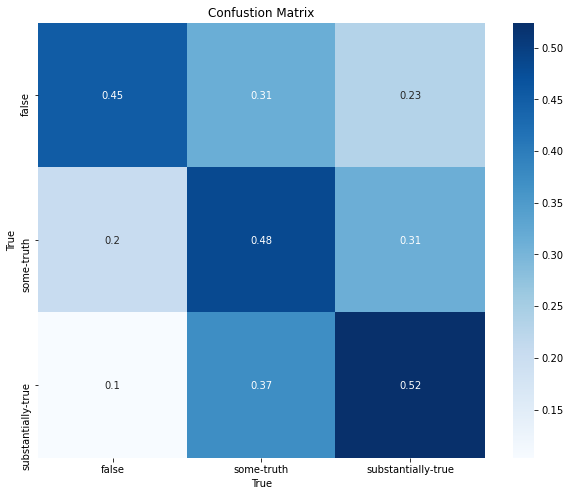

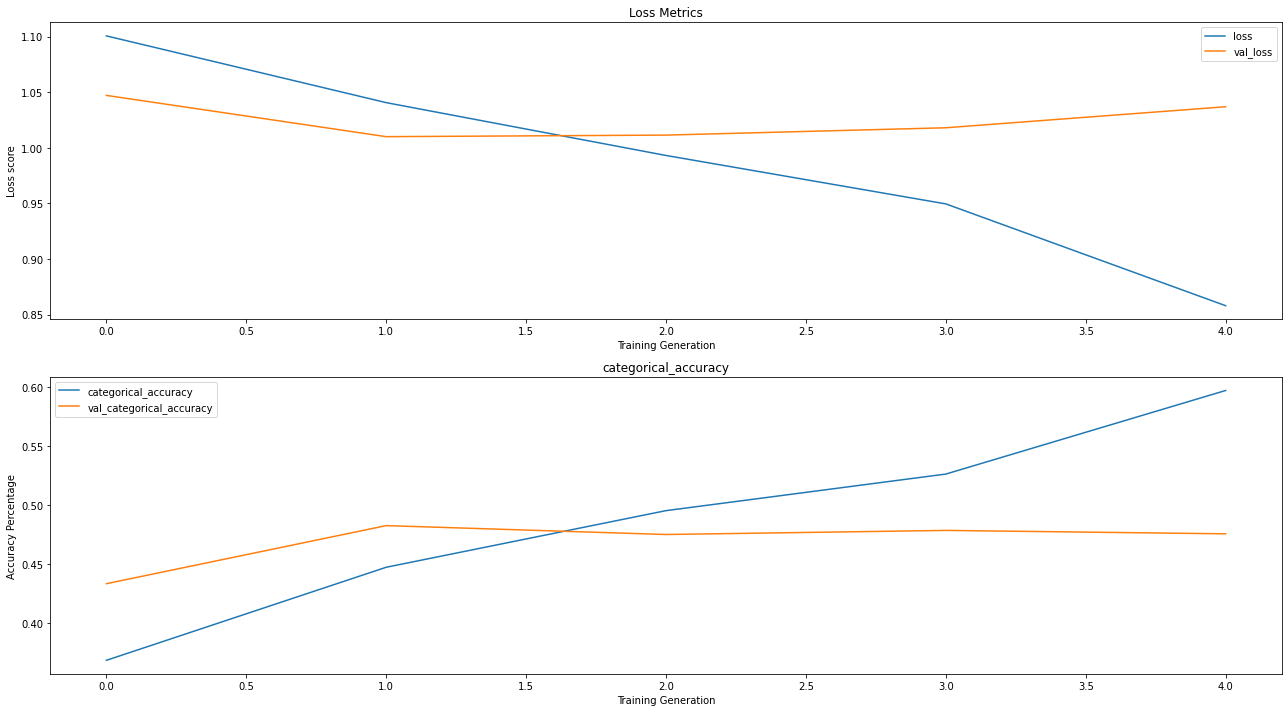

In [ ]:
# we define the filepath where any results will be saved
transformerModel_filepath = os.path.join('transformer_model_mapping1')

# the Callbacks for keras.Model.fit() method. See Keras documentation for more info.
transformerModelEarlyStop = EarlyStopping(patience = 3, mode = 'auto', restore_best_weights=False, monitor='val_categorical_accuracy')
transformerModelCheckpoint = ModelCheckpoint(transformerModel_filepath,save_best_only=True, monitor='val_categorical_accuracy')
transformerModelLRAdjust = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience=2, min_delta=.00000000001)

# This cell runs the fitting 
transformerModelHistory,params = create_model_visuals(
    model = transformerModel, 
    X_train= X_train_tokens, 
    y_train = y_train_map1,
    X_test = X_test_tokens,
    y_test = y_test_map1,
    epochs = 15, 
    batch_size=64,
    train = True,
    kwargs = {
        'class_weight' : class_weights,
        'validation_split': .1,
        'callbacks':[transformerModelEarlyStop, transformerModelCheckpoint, transformerModelLRAdjust]})

29/29 [==============================] - 0s 4ms/step - loss: 1.0160 - categorical_accuracy: 0.4851


,false,some-truth,substantially-true,Accuracy,Macro_Avg,Weighted_Avg
precision,0.595745,0.445378,0.447950,0.485149,0.496357,0.497259
recall,0.453074,0.483283,0.523985,0.485149,0.486781,0.485149
f1-score,0.514706,0.463557,0.482993,0.485149,0.487085,0.486739
support,309.000000,329.000000,271.000000,0.485149,909.000000,909.000000


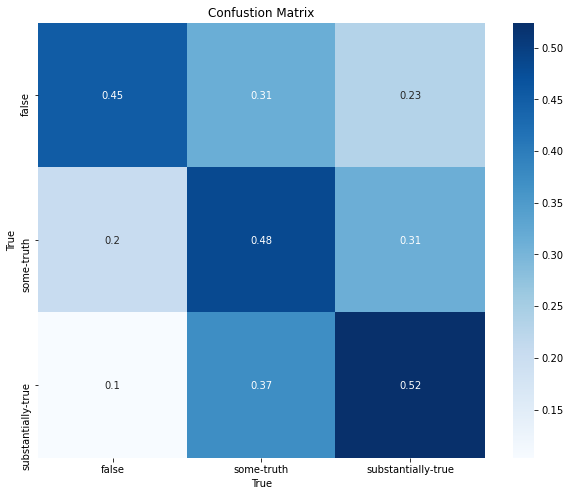

In [ ]:
checkpointTransformerModel = keras.models.load_model('transformer_model_mapping1')
checkpointTransformerModelHistory,checkpointTransformerModelParams  = create_model_visuals(
    model = transformerModel, 
    X_test = X_test_tokens,
    y_test = y_test_map1,
    train = False,
)

## Mapping 2

In [ ]:
def data_collapse(y, assignmentDict):
  return y.map(assignmentDict)

mapping2 = {
  'pants-fire' : 'false',
  'false' : 'false',
  'barely-true' : 'some-truth',
  'half-true' : 'some-truth',
  'mostly-true' : 'some-truth',
  'true' : 'true'
}



In [ ]:
y_train_map2 = data_collapse(y_train, mapping2)
y_test_map2 = data_collapse(y_test, mapping2)

y_train_map2_OH = pd.get_dummies(y_train_map2)
y_test_map2_OH = pd.get_dummies(y_test_map2)
display(y_train_map2.value_counts())

class_weights = compute_class_weight('balanced', y_train_map2_OH.columns, y_train_map2)
class_weights = {
    0 : class_weights[0],
    1 : class_weights[1],
    2 : class_weights[2],
}
print()
print(f'The weights are as follows: false : {class_weights[0]}, some-truth : {class_weights[1]}, true : {class_weights[2]}')

some-truth    8872
false         6149
true          2248
Name: truth_value, dtype: int64


The weights are as follows: false : 0.9361413780018432, some-truth : 0.6488202584911331, true : 2.5606465005931196


In [ ]:
# Only consider the first 50 words of each movie review
maxlen = 30

In [ ]:
embed_dim =  150 # Embedding size for each token
num_heads = 15  # Number of attention heads
ff_dim = 150  # Hidden layer size in feed forward network inside transformer

embedding_layer = TokenAndPositionEmbedding(maxlen, 20000, embed_dim)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

inputs = layers.Input(shape=(maxlen,))
x = embedding_layer(inputs)

x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.Orthogonal())(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.Orthogonal())(x)
outputs = layers.Dense(3, activation="softmax")(x)

transformerModel = keras.Model(inputs=inputs, outputs=outputs)
transformerModel.compile(keras.optimizers.RMSprop(momentum=.355), "categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
transformerModel.summary()


Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
token_and_position_embedding (None, 30, 150)           3004500   
_________________________________________________________________
transformer_block_48 (Transf (None, 30, 150)           136500    
_________________________________________________________________
global_average_pooling1d_38  (None, 150)               0         
_________________________________________________________________
dropout_196 (Dropout)        (None, 150)               0         
_________________________________________________________________
dense_440 (Dense)            (None, 100)               15100     
_________________________________________________________________
dropout_197 (Dropout)        (None, 100)               0  

Epoch 1/30
257/257 [==============================] - 4s 9ms/step - loss: 1.1340 - categorical_accuracy: 0.3517 - val_loss: 1.1071 - val_categorical_accuracy: 0.3125


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


Epoch 2/30
257/257 [==============================] - 2s 8ms/step - loss: 1.0655 - categorical_accuracy: 0.3669 - val_loss: 1.0877 - val_categorical_accuracy: 0.2998
Epoch 3/30
257/257 [==============================] - 2s 8ms/step - loss: 1.0192 - categorical_accuracy: 0.4096 - val_loss: 0.9815 - val_categorical_accuracy: 0.4062


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


Epoch 4/30
257/257 [==============================] - 2s 8ms/step - loss: 0.9739 - categorical_accuracy: 0.4354 - val_loss: 1.0360 - val_categorical_accuracy: 0.4271


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


Epoch 5/30
257/257 [==============================] - 2s 8ms/step - loss: 0.9208 - categorical_accuracy: 0.4861 - val_loss: 0.9746 - val_categorical_accuracy: 0.4931


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


Epoch 6/30
257/257 [==============================] - 2s 8ms/step - loss: 0.8585 - categorical_accuracy: 0.5270 - val_loss: 0.9832 - val_categorical_accuracy: 0.4664
Epoch 7/30
257/257 [==============================] - 2s 8ms/step - loss: 0.7996 - categorical_accuracy: 0.5724 - val_loss: 1.0303 - val_categorical_accuracy: 0.4502
Epoch 8/30
257/257 [==============================] - 2s 8ms/step - loss: 0.7288 - categorical_accuracy: 0.6236 - val_loss: 1.2053 - val_categorical_accuracy: 0.4317
Epoch 9/30
257/257 [==============================] - 2s 8ms/step - loss: 0.6765 - categorical_accuracy: 0.6665 - val_loss: 1.1524 - val_categorical_accuracy: 0.4514
Epoch 10/30
257/257 [==============================] - 2s 8ms/step - loss: 0.5895 - categorical_accuracy: 0.7184 - val_loss: 1.0975 - val_categorical_accuracy: 0.5081


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


INFO:tensorflow:Assets written to: transformer_model_mapping2/assets


Epoch 11/30
257/257 [==============================] - 2s 8ms/step - loss: 0.4589 - categorical_accuracy: 0.7903 - val_loss: 1.6902 - val_categorical_accuracy: 0.4387
Epoch 12/30
257/257 [==============================] - 2s 8ms/step - loss: 0.3682 - categorical_accuracy: 0.8373 - val_loss: 1.6434 - val_categorical_accuracy: 0.4676
Epoch 13/30
257/257 [==============================] - 2s 8ms/step - loss: 0.3202 - categorical_accuracy: 0.8546 - val_loss: 2.2769 - val_categorical_accuracy: 0.4919
Epoch 14/30
257/257 [==============================] - 2s 8ms/step - loss: 0.2670 - categorical_accuracy: 0.8866 - val_loss: 2.4327 - val_categorical_accuracy: 0.4421
Epoch 15/30
29/29 [==============================] - 0s 4ms/step - loss: 2.6215 - categorical_accuracy: 0.5171


,false,some-truth,true,Accuracy,Macro_Avg,Weighted_Avg
precision,0.481900,0.650667,0.141304,0.517052,0.424624,0.537262
recall,0.689320,0.488000,0.130000,0.517052,0.435773,0.517052
f1-score,0.567244,0.557714,0.135417,0.517052,0.420125,0.514496
support,309.000000,500.000000,100.000000,0.517052,909.000000,909.000000


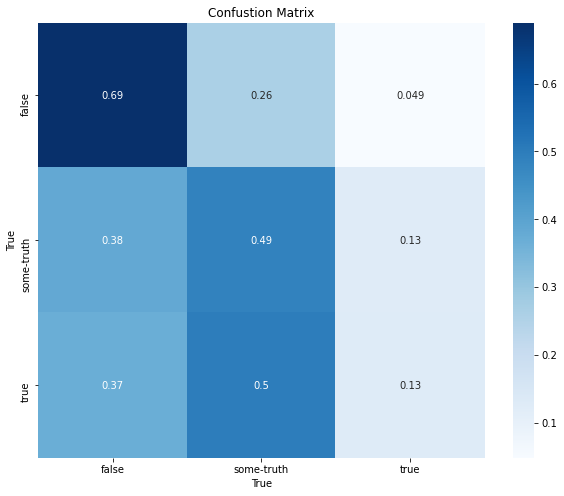

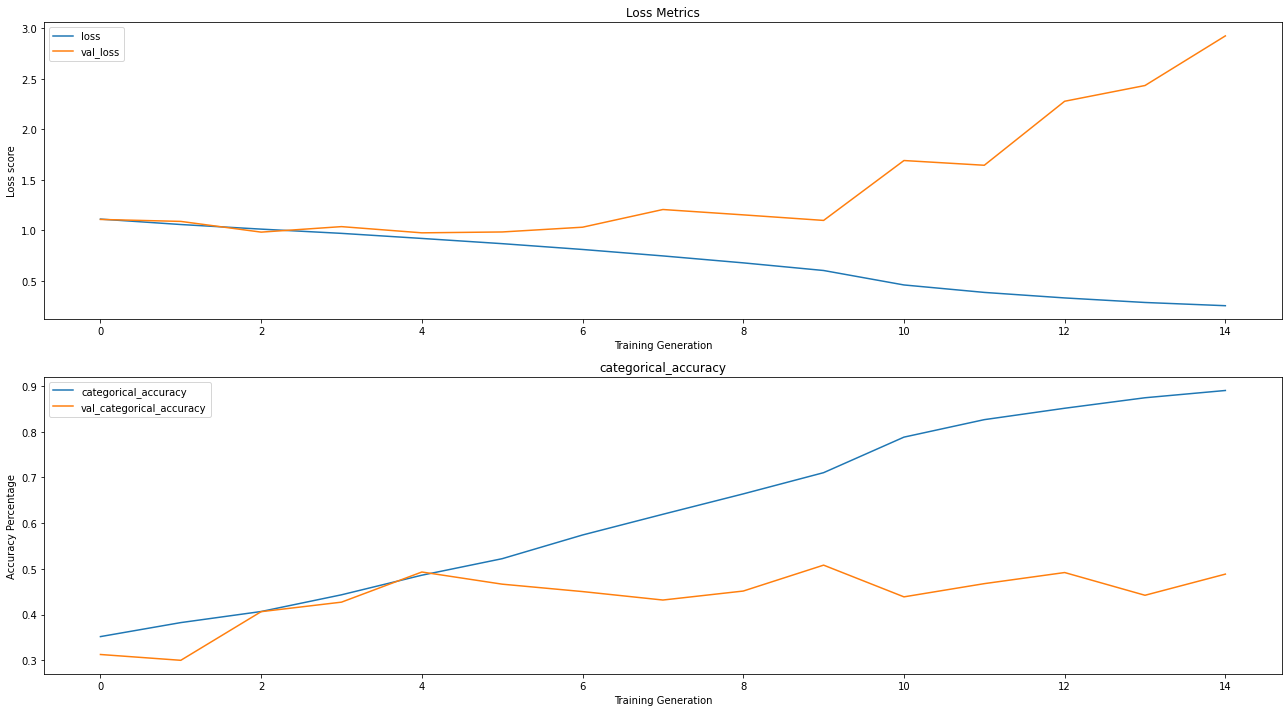

In [ ]:
# we define the filepath where any results will be saved
transformerModel_filepath = os.path.join('transformer_model_mapping2')

# the Callbacks for keras.Model.fit() method. See Keras documentation for more info.
transformerModelEarlyStop = EarlyStopping(patience = 5, mode = 'auto', restore_best_weights=False, monitor='val_categorical_accuracy')
transformerModelCheckpoint = ModelCheckpoint(transformerModel_filepath,save_best_only=True, monitor='val_categorical_accuracy')
transformerModelLRAdjust = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience=5, min_delta=.00000000001)

# This cell runs the fitting 
transformerModelHistory,params = create_model_visuals(
    model = transformerModel, 
    X_train= X_train_tokens, 
    y_train = y_train_map2,
    X_test = X_test_tokens,
    y_test = y_test_map2,
    epochs = 30, 
    batch_size=64,
    train = True,
    kwargs = {
        'class_weight' : class_weights,
        # 'class_weight' : {
            # 0:.8,
            # 1:.35,
            # 2:5
        # },
        'validation_split': .05,
        'callbacks':[
                     transformerModelEarlyStop, 
                     transformerModelCheckpoint, 
                     transformerModelLRAdjust
                     ]})

29/29 [==============================] - 0s 4ms/step - loss: 1.0038 - categorical_accuracy: 0.5688


,false,some-truth,true,Accuracy,Macro_Avg,Weighted_Avg
precision,0.597345,0.624567,0.200000,0.568757,0.473971,0.568607
recall,0.436893,0.722000,0.210000,0.568757,0.456298,0.568757
f1-score,0.504673,0.669759,0.204878,0.568757,0.459770,0.562498
support,309.000000,500.000000,100.000000,0.568757,909.000000,909.000000


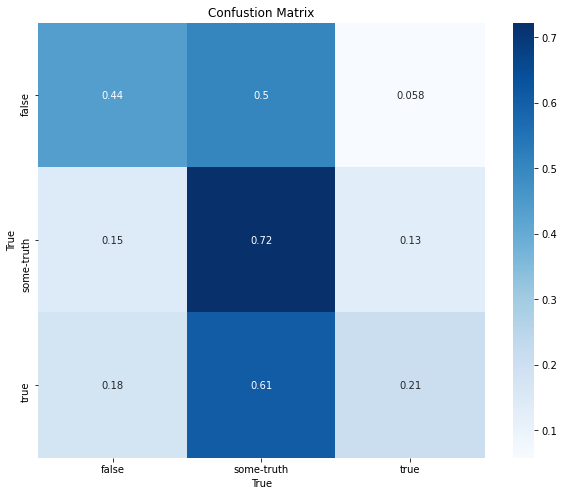

In [ ]:
transformerModel = keras.models.load_model('transformer_model_mapping2')
transformerModelHistory,params = create_model_visuals(
    model = transformerModel, 
    X_test = X_test_tokens,
    y_test = y_test_map2,
    train = False,
)

## Mapping 3

In [ ]:
def data_collapse(y, assignmentDict):
  return y.map(assignmentDict)

mapping3 = {
  'pants-fire' : 'false',
  'false' : 'false',
  'barely-true' : 'not-false',
  'half-true' : 'not-false',
  'mostly-true' : 'not-false',
  'true' : 'not-false'
}

In [ ]:
y_train_map3 = data_collapse(y_train, mapping3)
y_test_map3 = data_collapse(y_test, mapping3)

y_train_map3_OH = pd.get_dummies(y_train_map3)
y_test_map3_OH = pd.get_dummies(y_test_map3)
display(y_train_map3.value_counts())

class_weights = compute_class_weight('balanced', y_train_map3_OH.columns, y_train_map3)
class_weights = {
    0 : class_weights[0],
    1 : class_weights[1],
}
print()
print(f'The weights are as follows: false : {class_weights[0]}, some-truth : {class_weights[1]}')

not-false    11120
false         6149
Name: truth_value, dtype: int64


The weights are as follows: false : 1.4042120670027647, some-truth : 0.7764838129496403


In [ ]:
# Only consider the first 50 words of each movie review
maxlen = 30

In [ ]:
embed_dim =  150 # Embedding size for each token
num_heads = 15  # Number of attention heads
ff_dim = 150  # Hidden layer size in feed forward network inside transformer

embedding_layer = TokenAndPositionEmbedding(maxlen, 20000, embed_dim)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

inputs = layers.Input(shape=(maxlen,))
x = embedding_layer(inputs)

x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.Orthogonal())(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.Orthogonal())(x)
outputs = layers.Dense(2, activation="sigmoid")(x)

transformerModel = keras.Model(inputs=inputs, outputs=outputs)
transformerModel.compile(keras.optimizers.RMSprop(momentum=.355), "categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
transformerModel.summary()


Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
token_and_position_embedding (None, 30, 150)           3004500   
_________________________________________________________________
transformer_block_49 (Transf (None, 30, 150)           136500    
_________________________________________________________________
global_average_pooling1d_39  (None, 150)               0         
_________________________________________________________________
dropout_200 (Dropout)        (None, 150)               0         
_________________________________________________________________
dense_449 (Dense)            (None, 100)               15100     
_________________________________________________________________
dropout_201 (Dropout)        (None, 100)               0  

Epoch 1/40
243/243 [==============================] - 4s 10ms/step - loss: 0.7229 - categorical_accuracy: 0.5431 - val_loss: 0.6171 - val_categorical_accuracy: 0.6873


INFO:tensorflow:Assets written to: transformer_model_mapping3/assets


INFO:tensorflow:Assets written to: transformer_model_mapping3/assets


Epoch 2/40
243/243 [==============================] - 2s 8ms/step - loss: 0.6318 - categorical_accuracy: 0.6616 - val_loss: 0.6247 - val_categorical_accuracy: 0.6491
Epoch 3/40
243/243 [==============================] - 2s 9ms/step - loss: 0.5857 - categorical_accuracy: 0.7177 - val_loss: 0.5842 - val_categorical_accuracy: 0.7018


INFO:tensorflow:Assets written to: transformer_model_mapping3/assets


INFO:tensorflow:Assets written to: transformer_model_mapping3/assets


Epoch 4/40
243/243 [==============================] - 2s 9ms/step - loss: 0.5381 - categorical_accuracy: 0.7561 - val_loss: 0.6247 - val_categorical_accuracy: 0.6566
Epoch 5/40
243/243 [==============================] - 2s 9ms/step - loss: 0.4980 - categorical_accuracy: 0.7802 - val_loss: 0.6828 - val_categorical_accuracy: 0.6144
Epoch 6/40
243/243 [==============================] - 2s 9ms/step - loss: 0.4596 - categorical_accuracy: 0.7990 - val_loss: 0.6176 - val_categorical_accuracy: 0.6775
Epoch 7/40
243/243 [==============================] - 2s 8ms/step - loss: 0.4151 - categorical_accuracy: 0.8210 - val_loss: 0.6876 - val_categorical_accuracy: 0.6821
Epoch 8/40
243/243 [==============================] - 2s 8ms/step - loss: 0.3280 - categorical_accuracy: 0.8634 - val_loss: 0.7665 - val_categorical_accuracy: 0.6786
Epoch 9/40
243/243 [==============================] - 2s 8ms/step - loss: 0.2741 - categorical_accuracy: 0.8873 - val_loss: 0.9304 - val_categorical_accuracy: 0.6149
Epoc

,false,not-false,Accuracy,Macro_Avg,Weighted_Avg
precision,0.474227,0.760077,0.638064,0.617152,0.662907
recall,0.595469,0.660000,0.638064,0.627735,0.638064
f1-score,0.527977,0.706512,0.638064,0.617245,0.645822
support,309.000000,600.000000,0.638064,909.000000,909.000000


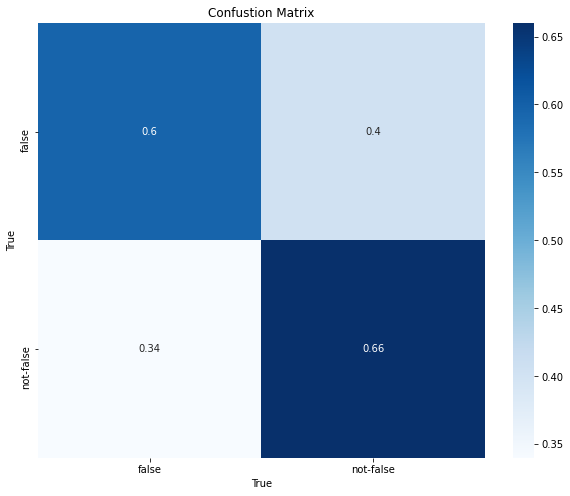

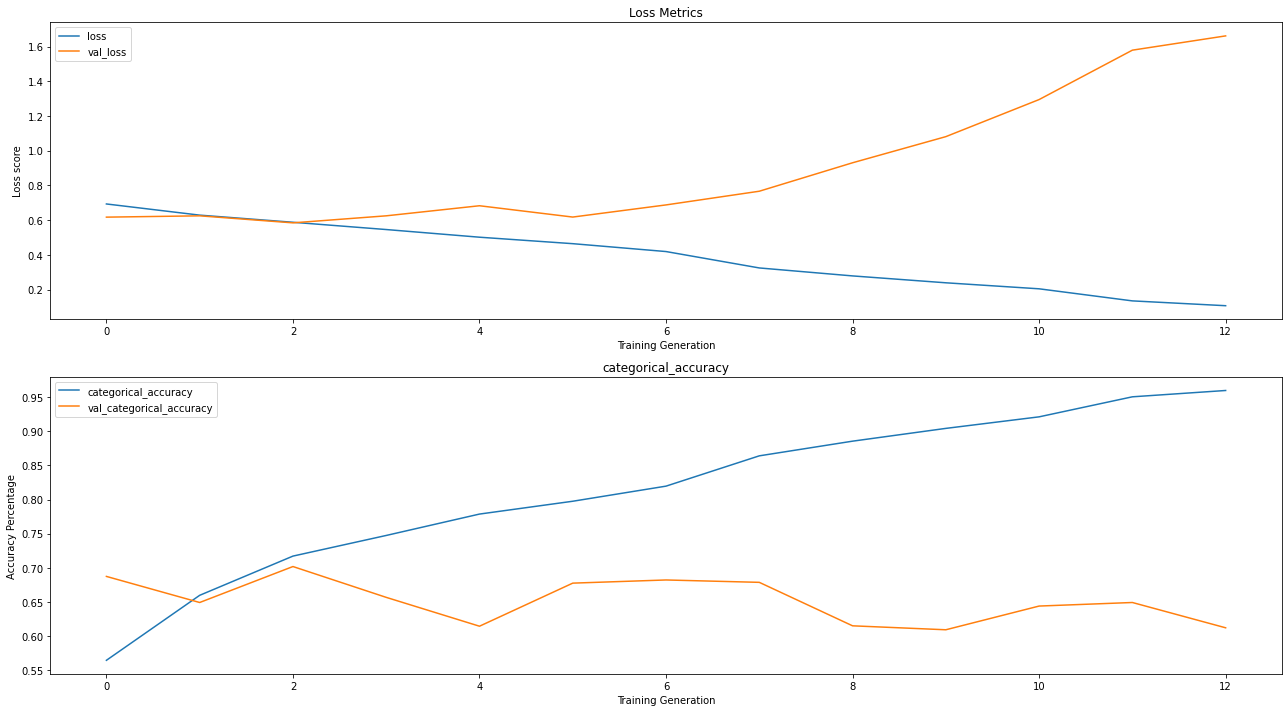

In [ ]:
# we define the filepath where any results will be saved
transformerModel_filepath = os.path.join('transformer_model_mapping3')

# the Callbacks for keras.Model.fit() method. See Keras documentation for more info.
transformerModelEarlyStop = EarlyStopping(patience = 10, mode = 'auto', restore_best_weights=False, monitor='val_categorical_accuracy')
transformerModelCheckpoint = ModelCheckpoint(transformerModel_filepath,save_best_only=True, monitor='val_categorical_accuracy')
transformerModelLRAdjust = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience=4, min_delta=.00000000001)

# This cell runs the fitting 
transformerModelHistory,params = create_model_visuals(
    model = transformerModel, 
    X_train= X_train_tokens, 
    y_train = y_train_map3,
    X_test = X_test_tokens,
    y_test = y_test_map3,
    epochs = 40, 
    batch_size=64,
    train = True,
    kwargs = {
        'class_weight' : class_weights,
        'validation_split': .1,
        'callbacks':[
                     transformerModelEarlyStop, 
                     transformerModelCheckpoint, 
                     transformerModelLRAdjust
                     ]})

29/29 [==============================] - 0s 4ms/step - loss: 0.5568 - categorical_accuracy: 0.7360


,false,not-false,Accuracy,Macro_Avg,Weighted_Avg
precision,0.714286,0.740642,0.735974,0.727464,0.731682
recall,0.372168,0.923333,0.735974,0.647751,0.735974
f1-score,0.489362,0.821958,0.735974,0.655660,0.708898
support,309.000000,600.000000,0.735974,909.000000,909.000000


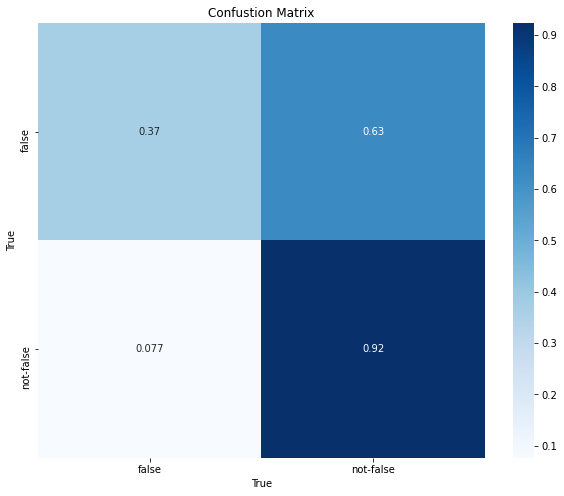

In [ ]:
transformerModel = keras.models.load_model('transformer_model_mapping3')
transformerModelHistory,params = create_model_visuals(
    model = transformerModel,
    X_test = X_test_tokens,
    y_test = y_test_map3,
    train = False,
)

# Glove Model Embedding

In [ ]:
# get path to glove models. This is specific to my google drive and will need to be changed
pathToGlove = 'drive/MyDrive/NLP Open Source Models/Glove/'

# create a dictionary with the word as the key and vectorized version as the value
glove = {}
with open(pathToGlove+'glove.6B.200d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove[word] = coefs

In [ ]:
# define out parameters for the embedding
num_tokens = len(vocab)
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

# loop through the vocab list and match them with words included in the glove model
for word, i in vocab_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
input_dim = embedding_matrix.shape[0]

Converted 15568 words (3906 misses)


# Extra stuff to be integrated or removed

,barely-true,false,half-true,mostly-true,pants-fire,true,Accuracy,Marro Avg,Weighted Avg
precision,0.250000,0.394904,0.227003,0.223404,0.517241,0.217949,0.275028,0.305084,0.306802
recall,0.082474,0.403471,0.463636,0.381818,0.067873,0.070833,0.275028,0.245018,0.275028
f1-score,0.124031,0.399142,0.304781,0.281879,0.120000,0.106918,0.275028,0.222792,0.247729
support,291.000000,461.000000,330.000000,275.000000,221.000000,240.000000,0.275028,1818.000000,1818.000000


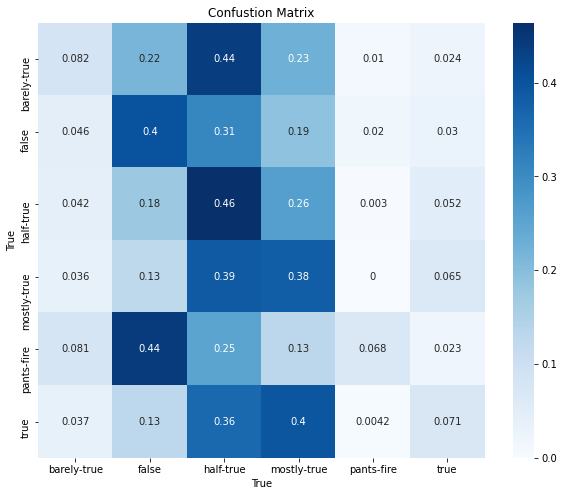

In [ ]:
confusionMatrix = confusion_matrix(y_test_eval, y_test_hat, normalize='true')
dfConfustionMatrix = pd.DataFrame(confusionMatrix, columns=y_test_OH.columns, index = y_test_OH.columns)
dfConfustionMatrix.index.name = 'Predictions'
dfConfustionMatrix.columns.name = 'True'
fig,ax = plt.subplots(1,1,figsize = (10,8))
sns.heatmap(
    dfConfustionMatrix, 
    annot=True, 
    cmap = 'Blues',
    ax = ax,
)
ax.set(title = 'Confustion Matrix')
report = pd.DataFrame.from_dict(classification_report(y_test_eval, y_test_hat,output_dict=True))
report.columns = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true', 'Accuracy', 'Marro Avg', 'Weighted Avg']
display(report)

In [ ]:
modelHistory = model.fit(
    X_train, 
    y_train_OH, 
    epochs=5, 
    batch_size=32, 
    validation_split=0.1,)

Epoch 1/5
461/461 [==============================] - 5s 8ms/step - loss: 1.7289 - categorical_accuracy: 0.2439 - val_loss: 1.6713 - val_categorical_accuracy: 0.2628
Epoch 2/5
461/461 [==============================] - 3s 7ms/step - loss: 1.6554 - categorical_accuracy: 0.2853 - val_loss: 1.6691 - val_categorical_accuracy: 0.2586
Epoch 3/5
461/461 [==============================] - 3s 7ms/step - loss: 1.6253 - categorical_accuracy: 0.2920 - val_loss: 1.6592 - val_categorical_accuracy: 0.2671
Epoch 4/5
461/461 [==============================] - 3s 7ms/step - loss: 1.5993 - categorical_accuracy: 0.3039 - val_loss: 1.7194 - val_categorical_accuracy: 0.2787
Epoch 5/5
461/461 [==============================] - 3s 7ms/step - loss: 1.5631 - categorical_accuracy: 0.3153 - val_loss: 1.6778 - val_categorical_accuracy: 0.2671


In [ ]:
model.evaluate(X_test, y_test_OH)
y_test_hat = model.predict(X_test)
y_test_hat = [x.argmax() for x in y_test_hat]
y_test_eval = [x.argmax() for x in y_test_OH.values]

57/57 [==============================] - 0s 4ms/step - loss: 1.7103 - categorical_accuracy: 0.2750


## functionize the model

,barely-true,false,half-true,mostly-true,pants-fire,true,Accuracy,Marro Avg,Weighted Avg
precision,0.250000,0.394904,0.227003,0.223404,0.517241,0.217949,0.275028,0.305084,0.306802
recall,0.082474,0.403471,0.463636,0.381818,0.067873,0.070833,0.275028,0.245018,0.275028
f1-score,0.124031,0.399142,0.304781,0.281879,0.120000,0.106918,0.275028,0.222792,0.247729
support,291.000000,461.000000,330.000000,275.000000,221.000000,240.000000,0.275028,1818.000000,1818.000000


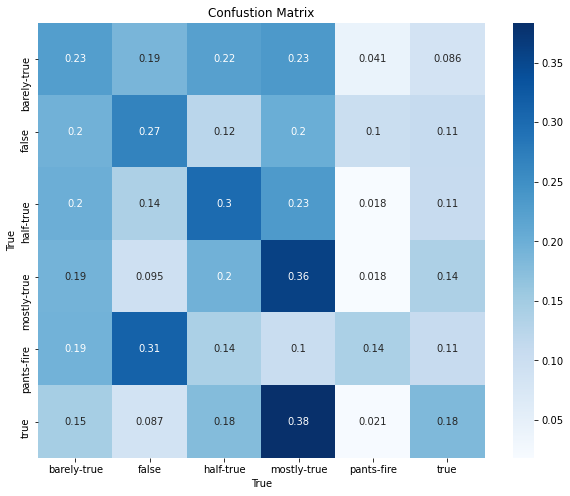

In [ ]:
  def create_matrix(X,y, normalize = 'true'):
    y_hat = model.predict(X)
    y_hat = [x.argmax() for x in y_hat]
    y_eval = [x.argmax() for x in y.values]
    confusionMatrix = confusion_matrix(y_eval, y_hat, normalize='true')
    dfConfustionMatrix = pd.DataFrame(confusionMatrix, columns=y.columns, index = y.columns)
    dfConfustionMatrix.index.name = 'Predictions'
    dfConfustionMatrix.columns.name = 'True'

    fig,ax = plt.subplots(1,1,figsize = (10,8))
    sns.heatmap(
        dfConfustionMatrix, 
        annot=True, 
        cmap = 'Blues',
        ax = ax,
    )
    ax.set(title = 'Confustion Matrix')
    report = pd.DataFrame.from_dict(classification_report(y_test_eval, y_test_hat,output_dict=True))
    report.columns = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true', 'Accuracy', 'Marro Avg', 'Weighted Avg']
    display(report)

create_matrix(X_test,y_test_OH)

## Baseline Model: Word2Vec Local Training?

In [ ]:
wordToVec = Word2Vec(sentences = X_train, size=200, window=35, min_count=1, workers=4)
wordToVec.train(X_train, total_examples=wordToVec.corpus_count, epochs=5)
wv = wordToVec.wv
display(wv.most_similar(positive = ["time"]))
display(wv['time'])


In [ ]:
thing = wv.get_keras_embedding()
thing

In [ ]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
list_tokenized_headlines = tokenizer.texts_to_sequences(X_train)
X_train_tokens = sequence.pad_sequences(list_tokenized_headlines, maxlen=200)

In [ ]:
model = Sequential()
embedding_size = 200
model.add(Embedding(20000, embedding_size, weights = ))
model.add(LSTM(10, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, None, 200)         22600     
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 10)          8440      
_________________________________________________________________
global_average_pooling1d_24  (None, 10)                0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 50)                550       
_________________________________________________________________
dropout_67 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 6)               

In [ ]:
modelHistory = model.fit(X_train_tokens, y = y_train_OH, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
display(wv.most_similar(positive = ["time"]))
display(wv['time'])


[('point', 0.7773004174232483),
 ('ex-president', 0.722303032875061),
 ('term', 0.6774725317955017),
 ('week', 0.674705445766449),
 ('century', 0.6672503352165222),
 ('point-in-time', 0.6590580940246582),
 ('president', 0.6516431570053101),
 ('decade', 0.6503779888153076),
 ('session', 0.6480398178100586),
 ('course', 0.6419240832328796)]

array([ 0.76711375,  0.8935672 , -1.1876911 , -0.3295918 , -0.06705547,
       -1.3076243 , -1.8133975 ,  0.69168943, -0.16471986,  0.71398264,
       -0.24640153, -0.20698534, -0.95611113,  0.25964814,  0.050776  ,
        0.972497  ,  1.6574346 , -0.13140863, -0.02349065,  1.2209971 ,
       -1.508631  , -0.03084175,  1.026226  ,  0.32340807,  0.38479125,
       -0.16057101, -0.3934429 , -0.6635785 , -0.06906135, -1.2750412 ,
       -1.4661082 ,  1.3415856 , -1.1921365 ,  0.7172722 , -0.96247035,
       -0.70197767,  0.70521677, -1.0516729 , -0.91379696,  0.268338  ,
        0.6374075 ,  1.6403053 ,  1.2662332 , -0.8399998 , -1.1651558 ,
       -0.833719  ,  0.8290142 , -1.4032991 ,  1.2890466 , -0.97319454,
        0.8947347 ,  1.0041395 ,  1.3192818 ,  0.7980006 ,  0.96280426,
       -0.72451246,  1.0957555 , -0.6391643 , -2.477614  , -0.30923206,
        2.3254921 , -0.24521753,  0.31153694, -0.97788614,  0.12351059,
       -0.91432196,  0.17733483, -2.1693728 ,  1.8002627 , -0.32


There are 24360 unique tokens in the dataset.


In [ ]:
# Initialize a text vectorizer object and set the max tokens and dimension of the output vectors
vectorizer = TextVectorization(max_tokens=20000 )

# Train the vectorizer on our corpus data
vectorizer.adapt(np.array(X_train))

# use built in method to get the vocab list
vocab = vectorizer.get_vocabulary()
vocab_index = dict(zip(vocab, range(len(vocab))))
print('There are {} unique tokens in the dataset.'.format(len(vocab)))

There are 19516 unique tokens in the dataset.


In [ ]:
def tokenize_corpus(X_train, maxTokens, TF_IDF = False, n_grams = None ):
  # Initialize a text vectorizer object and set the max tokens and dimension of the output vectors
  if TF_IDF == True:
    vectorizer = TextVectorization(max_tokens = maxTokens, ngrams = n_grams, output_mode = 'tf-idf')
  else:
    vectorizer = TextVectorization(max_tokens = maxTokens, ngrams = n_grams, output_mode = 'int')

  # Train the vectorizer on our corpus data
  vectorizer.adapt(np.array(X_train))

  # use built in method to get the vocab list
  vocab = vectorizer.get_vocabulary()
  vocab_index = dict(zip(vocab, range(len(vocab))))
  return vectorizer

In [ ]:
vectorizer_tfidf = tokenize_corpus(X_train, 20000, TF_IDF=True, n_grams=2)